# Normalization techniques

Explore different normalization techniques, adapted from large scale imagery to simplistic examples using 2d arrays

Original inspiration for the techniques applied :
- https://medium.com/sentinel-hub/how-to-normalize-satellite-images-for-deep-learning-d5b668c885af (linear normalization)
- https://arxiv.org/ftp/arxiv/papers/1710/1710.02939.pdf (gaussian and norm 2)
- https://www.nature.com/articles/s41597-022-01307-4 (dynamic world)

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler # Rescale arrays to 0, 100
from skimage import exposure
import scipy.stats as stats # Z-score normalization

## Notebook structure

- Create functions for histogram creation and normalization techniques
- Create 3 arrays (normal distribution, left skew, right skew)
- Visualize (plot) each type of distribution after with each normalization technique

In [95]:
def plot_histogram(arrays, titles: str, norm_type: str):
    
    num_plots = len(arrays)
    fig, axes = plt.subplots(1, num_plots, figsize=(5*num_plots, 5))
    
    plt.suptitle(norm_type)

    for i in range(num_plots):
        axes[i].hist(arrays[i], bins='auto')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(titles[i])
    
    plt.tight_layout()
    plt.show()


### Standard linear normalization
- The lower and upper bounds are set to 0, 1 respectively
- We set 1st and 99th percentile parameters (this will reduce outlier influence, can cause shift in the transformed distribution when skewed data)

In [79]:
def linear_normalization(array: np.ndarray):
    """
    Description : 
        Linear normalization of an array (with optional clipping)

    Parameters:
        array : numpy array
            The array to normalize

    Returns:
        numpy array
            The normalized array

    """

    # Set the maximum value to the 99th percentile
    max_value = np.percentile(array, 98)

    # Set the minimum value to the 1st percentile
    min_value = np.percentile(array, 2)

    # Set a bounds for the normalization
    a_lower, b_upper = 0, 1 

    return ((array - min_value)) * ( ( b_upper - a_lower ) / (max_value - min_value) ) + a_lower

### Dynamic world normalization

https://www.nature.com/articles/s41597-022-01307-4

In [107]:
def dynamic_world_normalization(array: np.ndarray, percentiles: list):
    
    lp, up = percentiles
    
    # First log transform the image
    epsilon = 1e-6  # A small value to avoid log(0)
    log_array = np.log(array * 0.005 + 1 + epsilon)

    # Obtain low/upper-percentiles for current channel
    lower_percentile = np.percentile(log_array, lp)
    upper_percentile = np.percentile(log_array, up)

    # Normalize the image adjusting its scale with the percentile bounds
    normalized_array = (log_array - lower_percentile) / (upper_percentile - lower_percentile)

    # Apply the sigmoid function to the image (transforms values to sigmoid function)
    normalized_array = 1 / (1 + np.exp(-normalized_array * 2))

    return normalized_array

### Histogram Equalization

Applications of this method in image transformation can be seen (and explained) in more detail here :
- https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html

In [12]:
def histogram_normalization(array: np.ndarray, extra_specs: str = "Equalization"):

    if extra_specs == "Equalization":
        array = exposure.equalize_hist(array)
        return array

    elif extra_specs == "Adaptive_Equalization":
        array = exposure.equalize_adapthist(array, clip_limit=0.03)
        return array

In [108]:
def histogram_equalization(array: np.ndarray):
    # Step 1: Calculate histogram
    hist, bins = np.histogram(array, bins=256, range=(0, 255))
    
    # Step 2: Calculate cumulative distribution function (CDF)
    cdf = hist.cumsum()
    
    # Step 3: Normalize the CDF
    cdf_normalized = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
    cdf_normalized = cdf_normalized.astype('uint8')
    
    # Step 4: Use the normalized CDF to transform the original array
    equalized_arr = np.interp(array, bins[:-1], cdf_normalized)
    
    return equalized_arr

### Gaussian normalization (standardization)

Paper : 
- https://arxiv.org/ftp/arxiv/papers/1710/1710.02939.pdf

In [13]:
def gaussian_normalization(array: np.ndarray):

    array = stats.zscore(array)
    return array

### Norm 2

Paper :
- https://arxiv.org/ftp/arxiv/papers/1710/1710.02939.pdf

In [110]:
def norm2_normalization(array: np.ndarray):

    array = np.array(array)
    array = array / np.sqrt(np.sum(array**2))
    return array

## Section 2:

- Histogram creation
- Visualizations

In [101]:
# Set a seed for reproducability
np.random.seed(80)

# Create the baseline distributions
normal_array = np.random.normal(loc=0, scale=1, size=1000)
right_skewed_array = np.random.gamma(shape=2, scale=2, size=1000)
left_skewed_array = -np.random.gamma(shape=2, scale=2, size=1000)

# Create a scaler for rescaling using min-max scaling to [0, 100]
def rescale(array):
    scaler = MinMaxScaler(feature_range=(0, 100))
    scaled_values = scaler.fit_transform(array.reshape(-1, 1)) # Reshape to 2D array
    return scaled_values.flatten() # Return to 1D array

# Rescale the arrays
normal_array = rescale(normal_array).astype(float)
right_skewed_array = rescale(right_skewed_array).astype(float)
left_skewed_array = rescale(left_skewed_array).astype(float)

# Array list
arrays = [normal_array, right_skewed_array, left_skewed_array]

# Title list
titles = ['Normal Distribution', 'Right Skewed Distribution', 'Left Skewed Distribution']

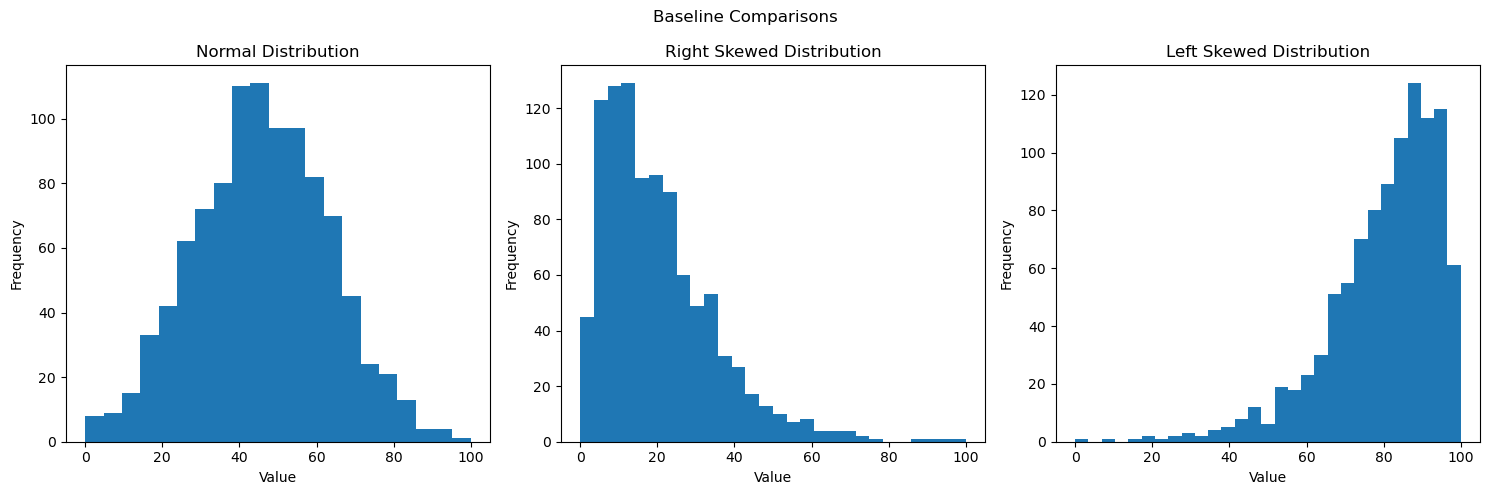

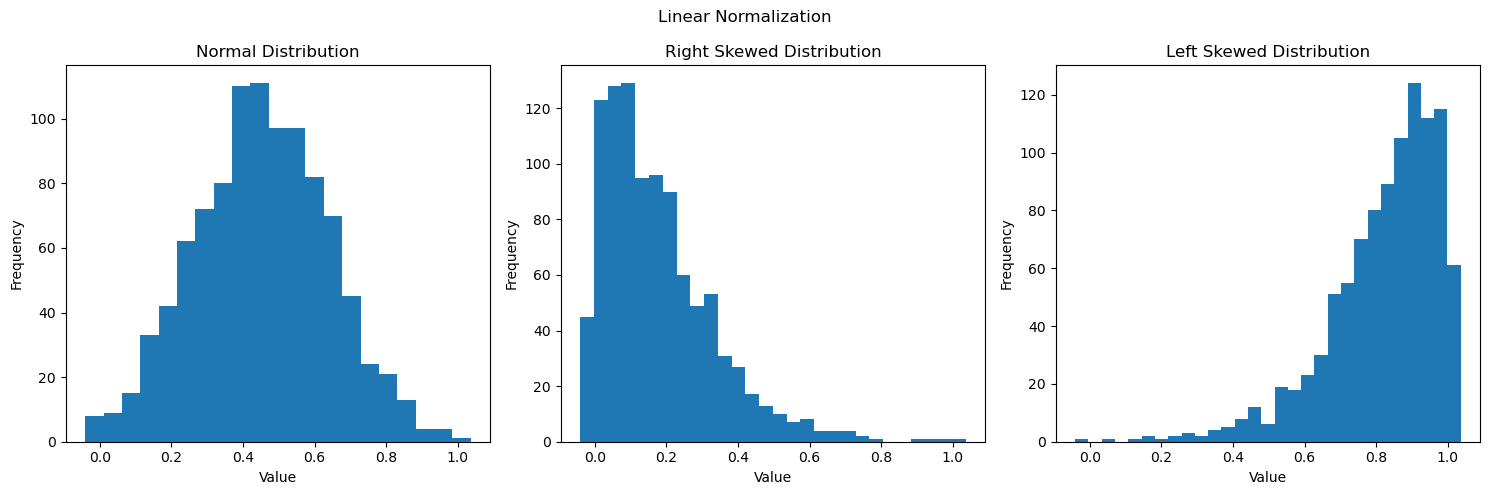

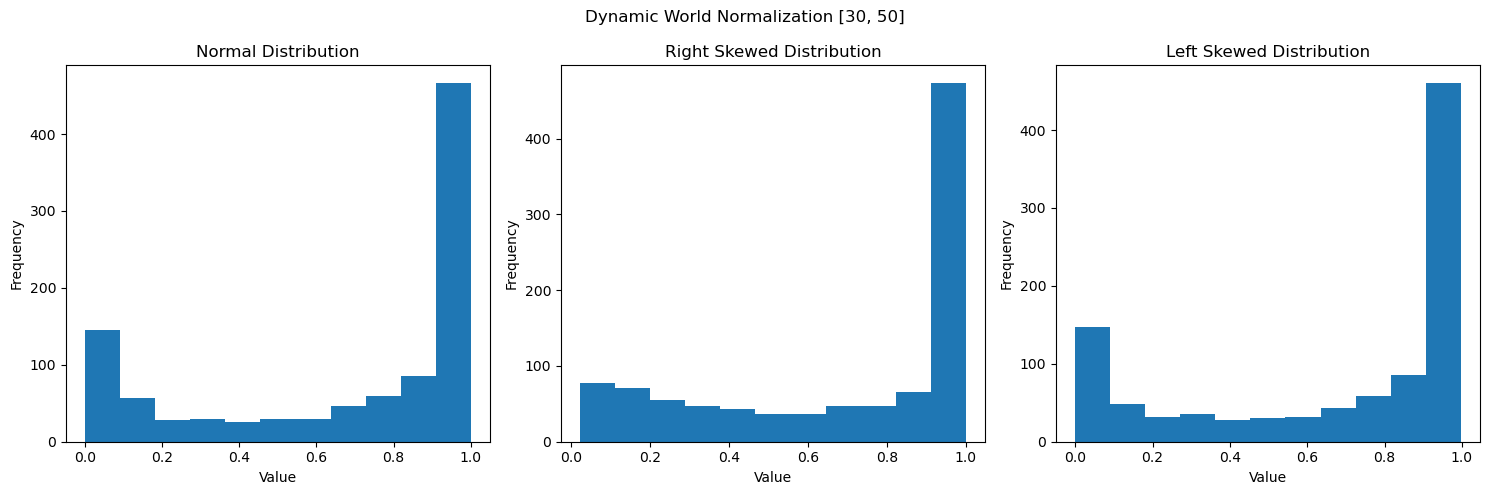

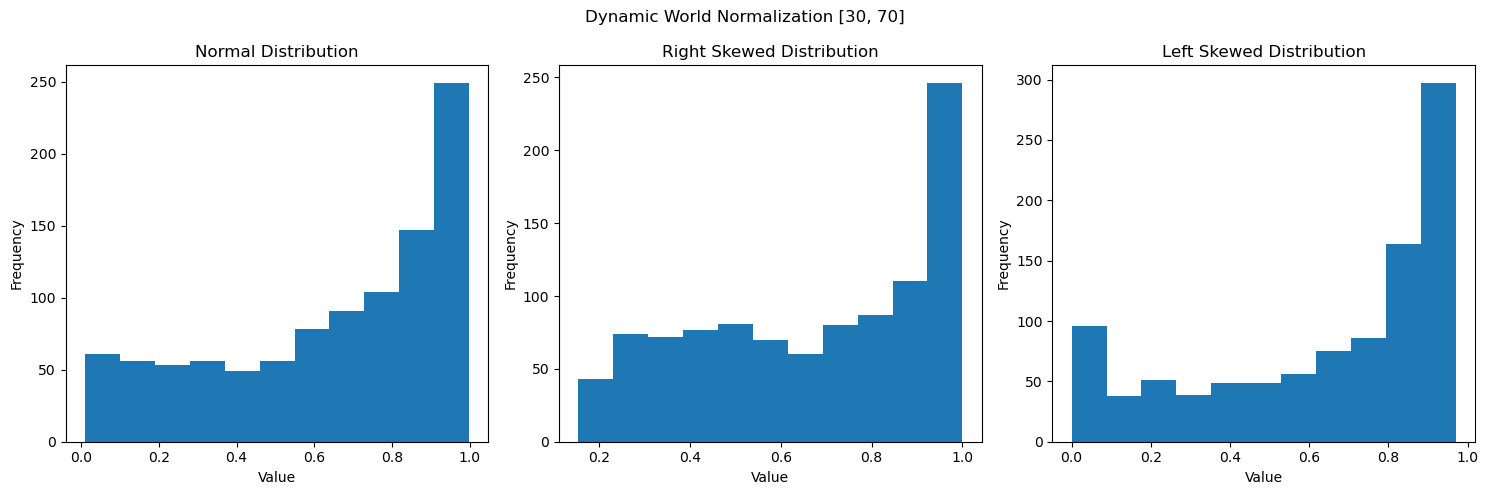

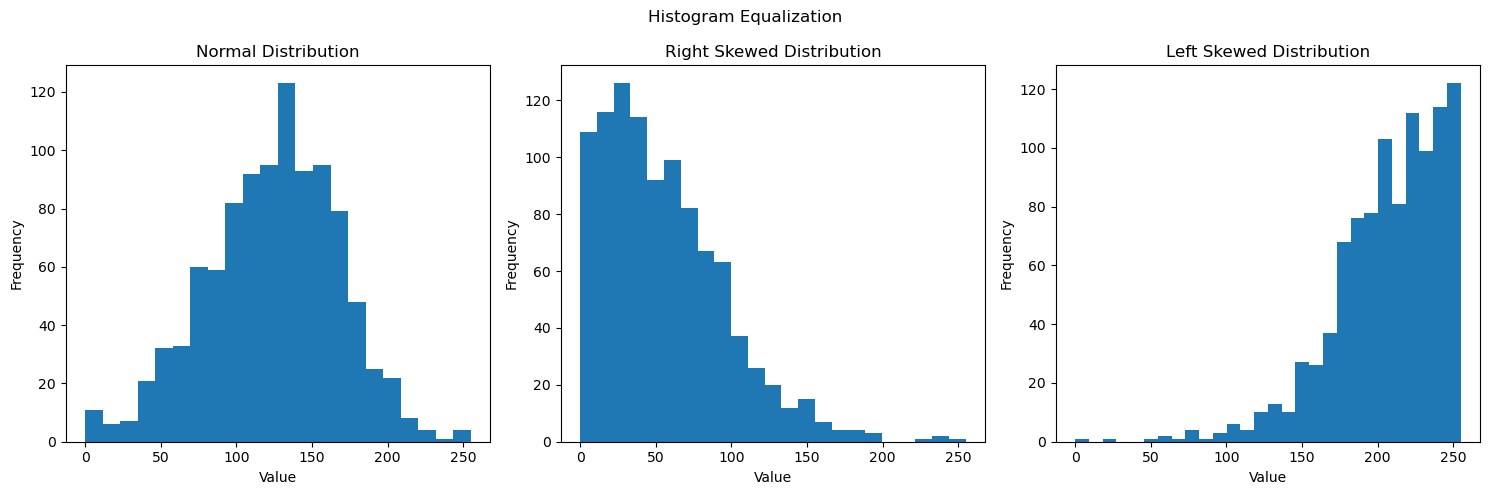

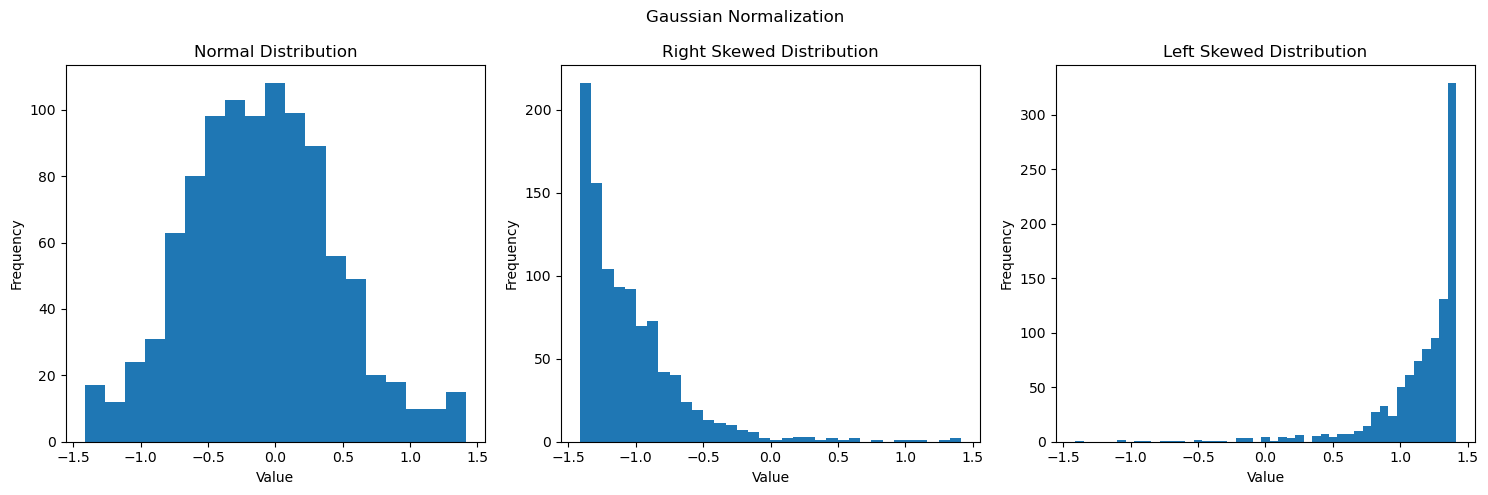

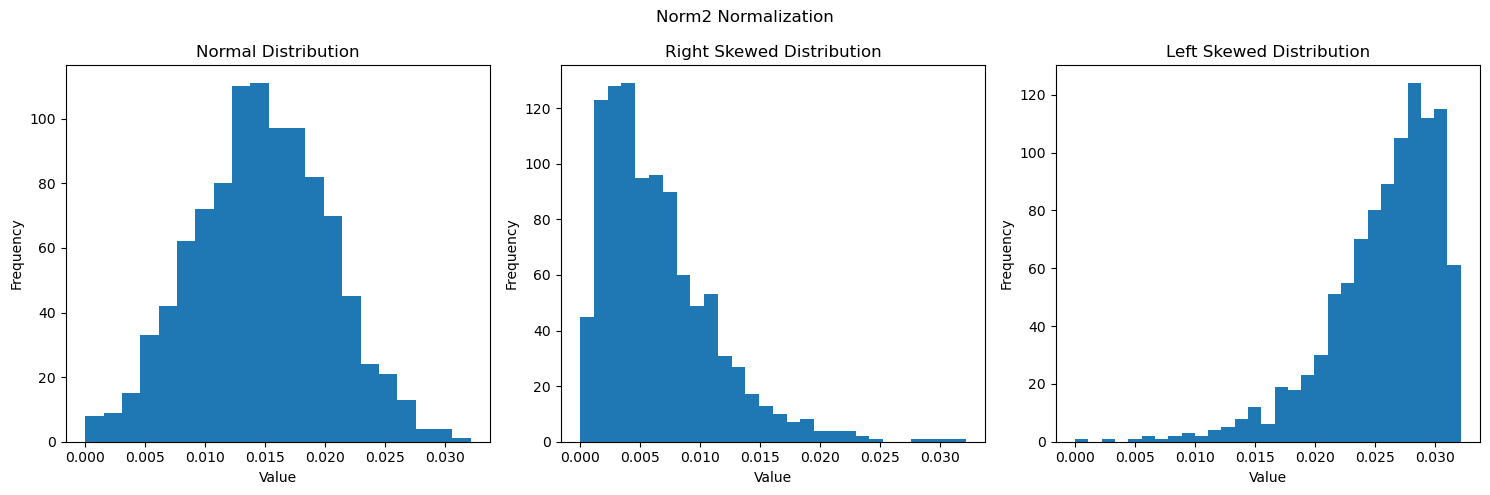

In [111]:
plot_histogram(arrays, titles, norm_type = 'Baseline Comparisons')
linear_norm_array = linear_normalization(arrays)
plot_histogram(linear_norm_array, titles, norm_type = 'Linear Normalization')
dynamic_world_normalization_3050 = [dynamic_world_normalization(arr, [30, 50]) for arr in arrays]
dynamic_world_normalization_3070 = [dynamic_world_normalization(arr, [30, 70]) for arr in arrays]
plot_histogram(dynamic_world_normalization_3050, titles, norm_type = 'Dynamic World Normalization [30, 50]')
plot_histogram(dynamic_world_normalization_3070, titles, norm_type = 'Dynamic World Normalization [30, 70]')
histogram_normalization_array_equalization = histogram_equalization(arrays)
# histogram_normalization_array_adaptive_equalization = histogram_normalization(arrays, extra_specs = "Adaptive_Equalization")
plot_histogram(histogram_normalization_array_equalization, titles, norm_type = 'Histogram Equalization')
# plot_histogram(histogram_normalization_array_adaptive_equalization, titles, norm_type = 'Adaptive Histogram Equalization')
gaussian_normalization_array = gaussian_normalization(arrays)
plot_histogram(gaussian_normalization_array, titles, norm_type = 'Gaussian Normalization')
norm2_normalization_array = norm2_normalization(arrays)
plot_histogram(norm2_normalization_array, titles, norm_type = 'Norm2 Normalization')
